# 5. Metrics Evaluation

> **Purpose:**  
> This notebook evaluates the **sensitivity of metrics** to perturbations in the extraction process.  
> Assuming that more sensitive metrics are better at discerning AAS quality under real-world conditions, we aim to identify the **most informative metrics** for evaluating both AAS and AAS extraction tools.

## 5.0 Imports

In [1]:
import sys
import os
import json
import glob
import hashlib
from itertools import product
import pickle
from metrics import SubmodelComparison
from scipy import stats
from scipy.stats import spearmanr
import basyx
from basyx.aas import model
from basyx.aas.adapter import aasx
from basyx.aas.model.submodel import SubmodelElementCollection, Property, MultiLanguageProperty, Range
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

data_path = "/app/data"
processing_path = os.path.join(data_path, "processed/sample")
config_path = os.path.join(processing_path, "configs")
log_path = os.path.join(processing_path, "experiment_log.csv")
log_df = pd.read_csv(log_path)

## 5.1 Filter Experiment Data

From all conducted experiments, relevant configurations are selected for analysis.
This step ensures that only valid and comparable trials are used in the metrics evaluation.

In [2]:

def filter_and_concat(
    df,
    fixed_filters=None,
    sweep=None,
    one_per_product_id=False,
    float_tolerance=1e-8 # numbers in experiment filenames maybe be cut off after a few decimal points
):
    """
    Filters a DataFrame by fixed columns and optionally sweeps over one or more columns.
    
    Args:
        df: Pandas DataFrame to filter.
        fixed_filters: Dict of fixed column filters (single values only).
                       Example: {"name": "trial1"}
        sweep: Dict of columns to sweep with lists of values.
               Example: {"model": ["gpt-4", "gpt-4o-mini"], "temperature": [0.5, 1.0]}
        one_per_product_id: Whether to deduplicate by product_id.
        float_tolerance: Tolerance for floating-point matching.

    Returns:
        Filtered concatenated DataFrame.
    """
    filtered_df = pd.DataFrame()
    fixed_filters = fixed_filters or {}
    sweep = sweep or {}

    # Generate all combinations of sweep values (cartesian product)
    sweep_keys = list(sweep.keys())
    sweep_values_product = product(*sweep.values()) if sweep else [()]

    for sweep_combo in sweep_values_product:
        subset = df.copy()

        # Apply fixed filters
        for col, val in fixed_filters.items():
            subset = subset[
                subset[col].between(val - float_tolerance, val + float_tolerance)
                if np.issubdtype(type(val), np.floating) else subset[col] == val
            ]

        # Apply sweep filters
        sweep_filters = dict(zip(sweep_keys, sweep_combo))
        for col, val in sweep_filters.items():
            subset = subset[
                subset[col].between(val - float_tolerance, val + float_tolerance)
                if np.issubdtype(type(val), np.floating) else subset[col] == val
            ]

        # Deduplicate if needed
        if one_per_product_id:
            subset = subset.sort_values("product_id").drop_duplicates("product_id", keep="last")

        # Print filter summary
        filter_summary = {**fixed_filters, **sweep_filters}
        print(f"{len(subset)} rows: {filter_summary}")

        filtered_df = pd.concat([filtered_df, subset], ignore_index=True)

    return filtered_df

log_df = pd.read_csv(log_path)
filtered_dfs = {}

# Qwen3 models as sweep
qwen3_models = ['qwen3:0.6b','qwen3:1.7b','qwen3:4b','qwen3:8b','qwen3:14b','qwen3:30b','qwen3:32b']
filtered_dfs['qwen3'] = filter_and_concat(
    log_df,
    fixed_filters={"name": "deepseek_40960_context"},
    sweep={"model": qwen3_models},
    one_per_product_id=True
)

# DeepSeek models as sweep
deepseek_models = ['deepseek-r1:1.5b','deepseek-r1:7b','deepseek-r1:8b','deepseek-r1:14b','deepseek-r1:32b','deepseek-r1:70b']
filtered_dfs['deepseek'] = filter_and_concat(
    log_df,
    fixed_filters={"name": "deepseek_40960_context"},
    sweep={"model": deepseek_models},
    one_per_product_id=True
)

# Temperature sweep for gpt-4o-mini
temperatures = np.linspace(1.2, 1.9, 8)
filtered_dfs['temperature'] = filter_and_concat(
    log_df,
    fixed_filters={"name": "experiments_test_sample_3", "model": "gpt-4o-mini"},
    sweep={"temperature": temperatures},
    one_per_product_id=True
)

# Prompt degradation sweep for gpt-4o-mini
intensities = np.linspace(0.0, 1.0, 11)
filtered_dfs['prompt'] = filter_and_concat(
    log_df,
    fixed_filters={"model": "gpt-4o-mini", "temperature": 0.0},
    sweep={"prompt_degradation_intensity": intensities},
    one_per_product_id=True
)

200 rows: {'name': 'deepseek_40960_context', 'model': 'qwen3:0.6b'}
200 rows: {'name': 'deepseek_40960_context', 'model': 'qwen3:1.7b'}
200 rows: {'name': 'deepseek_40960_context', 'model': 'qwen3:4b'}
200 rows: {'name': 'deepseek_40960_context', 'model': 'qwen3:8b'}
200 rows: {'name': 'deepseek_40960_context', 'model': 'qwen3:14b'}
200 rows: {'name': 'deepseek_40960_context', 'model': 'qwen3:30b'}
200 rows: {'name': 'deepseek_40960_context', 'model': 'qwen3:32b'}
200 rows: {'name': 'deepseek_40960_context', 'model': 'deepseek-r1:1.5b'}
200 rows: {'name': 'deepseek_40960_context', 'model': 'deepseek-r1:7b'}
200 rows: {'name': 'deepseek_40960_context', 'model': 'deepseek-r1:8b'}
200 rows: {'name': 'deepseek_40960_context', 'model': 'deepseek-r1:14b'}
200 rows: {'name': 'deepseek_40960_context', 'model': 'deepseek-r1:32b'}
200 rows: {'name': 'deepseek_40960_context', 'model': 'deepseek-r1:70b'}
200 rows: {'name': 'experiments_test_sample_3', 'model': 'gpt-4o-mini', 'temperature': np.floa

## 5.2 Metrics Comparison

Metrics are compared across experiments to assess their sensitivity and reliability.

### 5.2.1 Similarity Threshold Grid Search

A grid search over similarity thresholds is performed to evaluate how different cutoff values affect metric sensitivity and to select the optimal threshold.

In [ ]:

result_dfs_dict = {}
for high_thresh in list(np.linspace(0.5,1.0,51)): # Repeat calculations in steps of 0.1. 
    high_thresh = float(high_thresh)
    result_dfs = {}

    for key, df in filtered_dfs.items(): # iterate over all 4 perturbation types
        print(f"{key} filtered dataframe shape: {df.shape}")
        updated_rows = []

        for product_id in tqdm(df['product_id'].unique()): # iterate over all products
            product_df = df[df['product_id'] == product_id]
            
            company = product_id.split("_")[0]
            reference_path = os.path.join(processing_path, product_id, f"{product_id}_technical_data.json")
            paths = product_df['result_path'].tolist()
            comparison = SubmodelComparison(paths)
            comparison.high_thresh=high_thresh
            comparison.run()

            results_df = pd.DataFrame(comparison.results)

            # Combine metrics with original product_df
            product_df = product_df.reset_index(drop=True)
            results_df = results_df.reset_index(drop=True)
            merged_df = pd.concat([product_df, results_df], axis=1)
            merged_df['company'] = company
            merged_df['reference_path'] = reference_path
            updated_rows.append(merged_df)
        result_dfs[key] = pd.concat(updated_rows, ignore_index=True)
    result_dfs_dict[high_thresh]=result_dfs

grid_search_path = os.path.join(processing_path, 'threshold_grid_search1.pkl')
with open(grid_search_path, "wb") as f:
    pickle.dump(result_dfs_dict, f)

### 5.2.2 Correlation between Metrics and Perturbation Intensity

Correlations are computed to determine how well each metric responds to increasing perturbation intensity in the extraction process.
Higher correlation indicates that the metric is more effective in capturing the impact of perturbations.

In [3]:
import pickle
grid_search_path = os.path.join(processing_path, 'threshold_grid_search1.pkl')#grid_search.pkl')
with open(grid_search_path, "rb") as f:
    result_dfs_dict = pickle.load(f)

In [4]:
# metrics selected for evaluation out of all computed metrics
metrics = [
#  'total_reference_properties',
 'total_generated_properties',
#  'total_property_count_difference_raw',
#  'total_property_count_abs_difference_raw',
#  'one_to_one_matches',
#  'high_confidence_matches_embed',
#  'medium_confidence_matches_embed',
#  'low_confidence_matches_embed',
#  'mean_similarity_key_embed',
#  'high_confidence_matches_ratio',
#  'medium_confidence_matches_ratio',
#  'low_confidence_matches_ratio',
#  'mean_similarity_key_ratio',
 'key_recall_1to1',
 'key_precision_1to1',
 'key_f1_1to1',
 'key_recall_embed',
 'key_precision_embed',
 'key_f1_embed',
 'key_recall_ratio',
 'key_precision_ratio',
 'key_f1_ratio',
#  'total_reference_numeric',
#  'total_generated_numeric',
#  'mean_similarity_value_1to1',
#  'total_values_matched_1to1_numeric',
#  'total_values_matched_1to1_string',
#  'value_matches_1to1_numeric',
#  'value_matches_string_1to1_high_conf',
 'value_recall_1to1',
 'value_precision_1to1',
 'value_f1_1to1',
#  'mean_similarity_value_embed',
#  'total_values_matched_embed_numeric',
#  'total_values_matched_embed_string',
#  'value_matches_embed_numeric',
#  'value_matches_string_embed_high_conf',
 'value_recall_embed',
 'value_precision_embed',
 'value_f1_embed',
#  'mean_similarity_value_ratio',
#  'total_values_matched_ratio_numeric',
#  'total_values_matched_ratio_string',
#  'value_matches_ratio_numeric',
#  'value_matches_string_ratio_high_conf',
 'value_recall_ratio',
 'value_precision_ratio',
 'value_f1_ratio',
]

In [5]:
# one pivot_df per similarity threshold used in the metrics computations
pivot_dfs = {} 
for high_thresh,result_dfs in result_dfs_dict.items():
    result_dfs['qwen3']['parameters'] = result_dfs['qwen3']['model'].apply(lambda x: float(x.split(':')[1][:-1])) # Turn the model names into parameter counts in billions
    result_dfs['deepseek']['parameters'] = result_dfs['deepseek']['model'].apply(lambda x: float(x.split(':')[1][:-1]))
    correlation_results = []
    for key, df in result_dfs.items():
        if key == 'temperature':
            perturbation = 'temperature'
        elif key == 'prompt':
            perturbation = 'prompt_degradation_intensity'
        elif key in ['qwen3', 'deepseek']:
            perturbation = 'parameters'
        print(f"{'Key':<20} {'Perturbation':<40} {'Metric':<50} {'Correlation':>12} {'P-value':>12}")
        print("-" * 140)
        for metric in metrics:
            correlation, p_value = spearmanr(pd.to_numeric(df[perturbation]), df[metric].to_numpy())
            correlation_results.append({
                "Dataset": key,
                "Perturbation": perturbation,
                "Metric": metric,
                "Correlation": correlation,
                "P-Value": p_value
            })
            print(f"{key:<20} {perturbation:<40} {metric:50} {correlation:>12.4f} {p_value:>12.4f}")

    correlation_df = pd.DataFrame(correlation_results)

    n_samples = {key: len(df) for key, df in result_dfs.items()}
    n_samples['mean'] = sum(n_samples.values())
    correlation_df["AbsCorrelation"] = correlation_df["Correlation"].abs()
    pivot_df = correlation_df.pivot(index="Metric", columns="Dataset", values="AbsCorrelation")
    #pivot_df = pivot_df.abs()


    # Fisher z-transform
    def fisher_z(r):
        return 0.5 * np.log((1 + r) / (1 - r))

    # Inverse Fisher z-transform
    def inverse_fisher_z(z):
        return (np.exp(2 * z) - 1) / (np.exp(2 * z) + 1)

    # Standard error in z-space
    def fisher_z_se(n):
        return 1 / np.sqrt(n - 3)

    def var_z(n):
        return 1 / (n - 3)

    # Apply Fisher z, average, and inverse transform
    z_transformed = pivot_df.apply(fisher_z)
    weighted_values = sum([z_transformed[col] * (1/var_z(n_samples[col])) for col in z_transformed.columns])

    total_weight = sum(1/var_z(np.array([n_samples[col] for col in z_transformed.columns])))

    z_transformed['mean'] = weighted_values / total_weight

    #z_transformed['mean'] = z_transformed.mean(axis=1)
    for key, n in n_samples.items():
        z_transformed[key+'_upper'] = z_transformed[key] + fisher_z_se(n_samples[key])
        z_transformed[key+'_lower'] = (z_transformed[key] - fisher_z_se(n_samples[key])).clip(lower=0)

    pivot_df = z_transformed.apply(inverse_fisher_z)
    pivot_df = pivot_df.sort_values(by="mean", ascending=False)
    pivot_dfs[high_thresh]=pivot_df


Key                  Perturbation                             Metric                                              Correlation      P-value
--------------------------------------------------------------------------------------------------------------------------------------------
qwen3                parameters                               total_generated_properties                               0.2004       0.0000
qwen3                parameters                               key_recall_1to1                                          0.3797       0.0000
qwen3                parameters                               key_precision_1to1                                       0.2988       0.0000
qwen3                parameters                               key_f1_1to1                                              0.3816       0.0000
qwen3                parameters                               key_recall_embed                                         0.3740       0.0000
qwen3                para

In [6]:
thresholds = {}
# compute best threshold & correlation per metric
for metric in metrics:
    best_threshold = None
    best_corr = float('-inf')  # start from very low
    for high_thresh, pivot_df in pivot_dfs.items():
        current = pivot_df.loc[pivot_df.index == metric, 'mean'].values[0]
        if current > best_corr:
            best_corr = current
            best_threshold = high_thresh
    thresholds[metric] = (best_threshold, best_corr)

# find metric with the highest correlation overall
best_metric, (best_threshold, best_corr) = max(
    thresholds.items(), key=lambda x: x[1][1]
)

print(f"Highest correlation: {best_corr}")
print(f"Threshold: {best_threshold}")
print(f"Metric: {best_metric}")
result_dfs = result_dfs_dict[best_threshold] # 0.88
pivot_df = pivot_dfs[best_threshold]

Highest correlation: 0.6582914466965583
Threshold: 0.88
Metric: value_recall_1to1


/tmp/ipykernel_29631/3074821062.py:47: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  ax.errorbar(
/tmp/ipykernel_29631/3074821062.py:61: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  ax.errorbar(


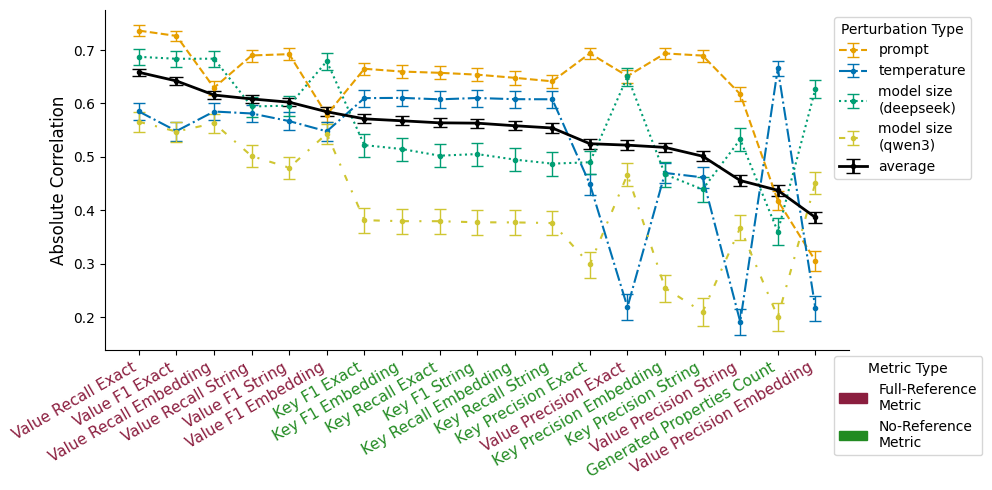

In [7]:
# Full-reference metrics color: #8B1E3F
# No-reference metrics color: #228B22
label_mapping = {
    'value_recall_1to1': ("Value Recall Exact", "#8B1E3F"),
    'total_generated_properties': ("Generated Properties Count", "#228B22"),
    'key_recall_1to1': ("Key Recall Exact", "#228B22"),
    'key_precision_1to1': ("Key Precision Exact", "#228B22"),
    'key_f1_1to1': ("Key F1 Exact", "#228B22"),
    'key_recall_embed': ("Key Recall Embedding", "#228B22"),
    'key_precision_embed': ("Key Precision Embedding", "#228B22"),
    'key_f1_embed': ("Key F1 Embedding", "#228B22"),
    'key_recall_ratio': ("Key Recall String", "#228B22"),
    'key_precision_ratio': ("Key Precision String", "#228B22"),
    'key_f1_ratio': ("Key F1 String", "#228B22"),
    'value_recall_1to1': ("Value Recall Exact", "#8B1E3F"),
    'value_precision_1to1': ("Value Precision Exact", "#8B1E3F"),
    'value_f1_1to1': ("Value F1 Exact", "#8B1E3F"),
    'value_recall_embed': ("Value Recall Embedding", "#8B1E3F"),
    'value_precision_embed': ("Value Precision Embedding", "#8B1E3F"),
    'value_f1_embed': ("Value F1 Embedding", "#8B1E3F"),
    'value_recall_ratio': ("Value Recall String", "#8B1E3F"),
    'value_precision_ratio': ("Value Precision String", "#8B1E3F"),
    'value_f1_ratio': ("Value F1 String", "#8B1E3F"),
    }

# Colors for perturbation types
# Colorblind-friendly Okabe–Ito palette
colors = [
    "#E69F00",  # orange
    "#0072B2",  # blue
    "#009E73",  # bluish green
    "#CFC632",  # yellow
    "#56B4E9",  # sky blue
]
linestyles = ['--', '-.', ':', (0, (3, 5, 1, 5))]#['-', '--', '-.', ':', (0, (3, 5, 1, 5))]
model_names = ['prompt', 'temperature', 'deepseek', 'qwen3']
x = np.arange(len(pivot_df))

fig, ax = plt.subplots(figsize=(10, 5))

for i, model in enumerate(model_names):
    y = pivot_df[model]
    yerr_lower = y - pivot_df[f"{model}_lower"]
    yerr_upper = pivot_df[f"{model}_upper"] - y
    yerr = np.vstack([yerr_lower, yerr_upper])
    
    ax.errorbar(
        x, y, yerr=yerr, label=model,
        color=colors[i], linestyle=linestyles[i],
        linewidth=1.5, fmt='-o', capsize=4,
        markersize=3, elinewidth=1
    )

# Aggregate line
agg_color = "black"
y = pivot_df["mean"]
yerr_lower = y - pivot_df["mean_lower"]
yerr_upper = pivot_df["mean_upper"] - y
yerr = np.vstack([yerr_lower, yerr_upper])

ax.errorbar(
    x, y, yerr=yerr, label="average",
    color=agg_color, linestyle='-', linewidth=2,
    fmt='-o', capsize=5, markersize=3, elinewidth=2
)

# Axis labels & formatting
ax.set_ylabel("Absolute Correlation", fontsize=12)

# Replace labels & set colors
new_labels = []
tick_colors = []
for old_label in pivot_df.index:
    if old_label in label_mapping:
        new_labels.append(label_mapping[old_label][0])
        tick_colors.append(label_mapping[old_label][1])
    else:
        new_labels.append(old_label)  # fallback
        tick_colors.append("black")

ax.set_xticks(x)
ax.set_xticklabels(new_labels, rotation=30, ha='right', fontsize=11)

# Apply tick colors
for ticklabel, color in zip(ax.get_xticklabels(), tick_colors):
    ticklabel.set_color(color)

# Legend for datasets
legend_1 = ax.legend(labels = ['prompt','temperature','model size\n(deepseek)','model size\n(qwen3)', 'average'], title="Perturbation Type", bbox_to_anchor=(0.97, 1), loc='upper left', fontsize=10)
ax.add_artist(legend_1)

unique_color_map = {}
for old_label, (new_name, color) in label_mapping.items():
    if color not in unique_color_map:
        unique_color_map[color] = new_name
# Legend for metric colors
color_patches = [
    mpatches.Patch(color=color, label=name)
    for color, name in zip(unique_color_map.keys(),['Full-Reference\nMetric', 'No-Reference\nMetric'])
]
legend_2 = ax.legend(handles=color_patches, title="Metric Type", bbox_to_anchor=(0.97, -0.33), loc='lower left', fontsize=10)

# Remove unnecessary spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(r"figure4.svg", dpi=300, bbox_inches="tight")
plt.show()


## 5.3 Perturbations Comparison

The effect of **different perturbation types** on the extracted AAS is compared.
This analysis helps identify which perturbations have the largest impact.


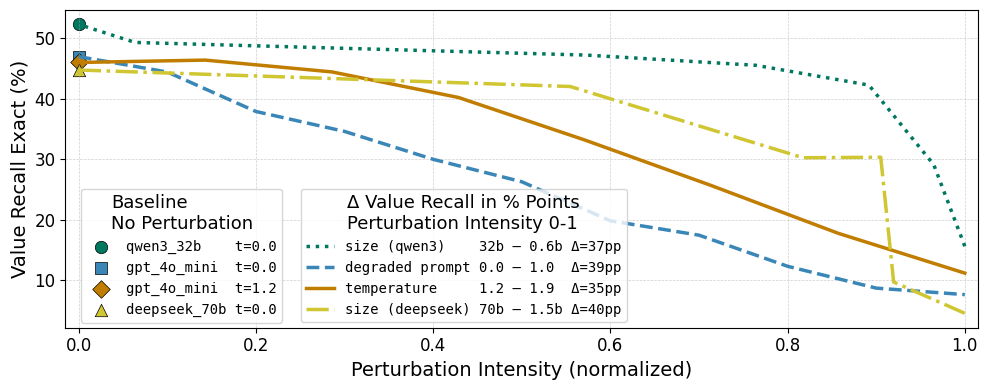

In [8]:

# Slightly darker, print-safe colors (based on Okabe-Ito palette)
color_map = {
    'temperature': '#C07D00',  # darker orange
    'prompt': '#3A87B7',       # darker blue
    'qwen3': '#00775F',        # darker green
    'deepseek': '#CFC632'      # darker yellow
}

# Line styles for each perturbation
linestyles = {
    'temperature': 'solid',
    'prompt': 'dashed',
    'qwen3': 'dotted',
    'deepseek': 'dashdot'
}

# Create figure
metric = 'value_recall_1to1'
fig = plt.figure(figsize=(10, 4))
ax = fig.gca()

# Define plot order
plot_order = ['qwen3', 'prompt', 'temperature', 'deepseek']

# Containers for manual legend building
line_handles = []
line_labels = []

# Plot perturbation curves
for key in plot_order:
    if key not in result_dfs:
        continue
    df = result_dfs[key]

    if key == 'temperature':
        perturbation = 'temperature'
        name = 'temperature'
        range_ = '1.2 – 1.9 '
    elif key == 'prompt':
        perturbation = 'prompt_degradation_intensity'
        name = 'degraded prompt'
        range_ = '0.0 – 1.0 '
    elif key == 'qwen3':
        perturbation = 'parameters'
        name = 'size (qwen3)'
        range_ = '32b – 0.6b'
    elif key == 'deepseek':
        perturbation = 'parameters'
        name = 'size (deepseek)'
        range_ = '70b – 1.5b'

    mean_df = df.groupby(perturbation)[metric].mean()

    x_values = (mean_df.index - min(mean_df.index)) / (max(mean_df.index) - min(mean_df.index))
    if key in ['deepseek', 'qwen3']:
        x_values = (-mean_df.index - min(-mean_df.index)) / (max(-mean_df.index) - min(-mean_df.index))

    reduction = abs(mean_df.values[0] - mean_df.values[-1]) * 100

    label_text = f"{name.ljust(15)} {range_.ljust(8)} Δ={reduction:.0f}pp"
    handle, = ax.plot(x_values, mean_df.values * 100,
                      label=label_text,
                      color=color_map[key],
                      linestyle=linestyles[key],
                      linewidth=2.5,
                      alpha=1)
    line_handles.append(handle)
    line_labels.append(label_text)

# Baseline values (aligned with same order)
baseline_means = {
    'qwen3_32b': result_dfs['qwen3'][result_dfs['qwen3']['parameters'] == 32]['value_recall_1to1'].mean(),
    'gpt_4o_mini_t0': result_dfs['prompt'][result_dfs['prompt']['prompt_degradation_intensity'] == 0.0]['value_recall_1to1'].mean(),
    'gpt_4o_mini_t1.2': result_dfs['temperature'][result_dfs['temperature']['temperature'] == 1.2]['value_recall_1to1'].mean(),
    'deepseek_70b': result_dfs['deepseek'][result_dfs['deepseek']['parameters'] == 70]['value_recall_1to1'].mean(),
}

baseline_labels = {
    'qwen3_32b': 'qwen3_32b    t=0.0',
    'gpt_4o_mini_t0': 'gpt_4o_mini  t=0.0',
    'gpt_4o_mini_t1.2': 'gpt_4o_mini  t=1.2',
    'deepseek_70b': 'deepseek_70b t=0.0',
}

baseline_colors = [
    color_map['qwen3'],
    color_map['prompt'],
    color_map['temperature'],
    color_map['deepseek']
]

baseline_markers = ['o', 's', 'D', '^']
baseline_keys = ['qwen3_32b', 'gpt_4o_mini_t0', 'gpt_4o_mini_t1.2', 'deepseek_70b']

# Plot baseline markers
marker_handles = []
for i, key in enumerate(baseline_keys):
    sc = ax.scatter([0], [baseline_means[key]*100],
                    s=80,
                    marker=baseline_markers[i],
                    color=baseline_colors[i],
                    edgecolors='black',
                    linewidths=0.5,
                    label=baseline_labels[key])
    marker_handles.append(sc)

# --- Legends ---

# Legend for lines
legend1 = ax.legend(line_handles, line_labels,
                    title='Δ Value Recall in % Points\nPerturbation Intensity 0-1',
                    fontsize=12, title_fontsize=13,
                    prop={'family': 'monospace'},
                    loc='upper left',
                    bbox_to_anchor=(0.25, 0.46))
ax.add_artist(legend1)

# Legend for baseline markers
legend2 = ax.legend(marker_handles, [baseline_labels[k] for k in baseline_keys],
                    title='Baseline\nNo Perturbation',
                    fontsize=12, title_fontsize=13,
                    prop={'family': 'monospace'},
                    loc='upper left',
                    bbox_to_anchor=(0.01, 0.46))

# Axis formatting
ax.set_xlabel("Perturbation Intensity (normalized)", fontsize=14)
ax.set_ylabel("Value Recall Exact (%)", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

# Grid
ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.6)

plt.rcParams['font.family'] = 'serif'

# Tight layout and export
ax.set_xlim(-0.015, 1.015)
plt.tight_layout()
# plt.savefig("value_recall_perturbation.pdf", dpi=300, bbox_inches='tight')
plt.savefig(r"figure5.svg", dpi=300, bbox_inches="tight")
plt.show()


## 5.4 Product Segment and Manufacturer Comparison

Comparison of metrics across **product segments** and **manufacturers** provides insights into AAS consistency and tool performance across categories.

### 5.4.1
Plots for data exploration.

In [ ]:
# Avoiding direct company evaluations in the publication
# different pseudonyms compared to the publication to avoid any confusion
def pseudonymize_company(company):
    if company == "Festo":
        return 'Company 1'
    if company == "Harting":
        return 'Company 2'
    if company == "RStahl":
        return 'Company 3'
    if company == "Wago":
        return 'Company 4'

companies = ['Festo', 'Harting', 'RStahl', 'Wago']

# Load metadata
metadata_df = pd.read_csv(os.path.join(processing_path, 'metadata.csv'))

# Top 3 performance metrics (from pivot_df)
best_metrics = pivot_df.index[:3].to_list()

# To store individual DataFrames and table rows for printing
dfs = []
rows = []

# Process each company
for company in companies:
    # Filter data from each source
    df_qwen = result_dfs['qwen3'][
        (result_dfs['qwen3']['company'] == company) & 
        (result_dfs['qwen3']['parameters'] == 32) # best qwen model in our experiments
    ]
    df_deepseek = result_dfs['deepseek'][
        (result_dfs['deepseek']['company'] == company) & 
        (result_dfs['deepseek']['parameters'] == 70) # best deepseek model in our experiments
    ]
    df_prompt = result_dfs['prompt'][
        (result_dfs['prompt']['company'] == company) & 
        (result_dfs['prompt']['prompt_degradation_intensity'] == 0.0) # gpt_4o_mini without perturbations
    ]

    # Combine data
    df = pd.concat([df_qwen, df_deepseek, df_prompt])

    # Add anonymized company name
    company_name = pseudonymize_company(company)
    df['Company'] = company_name

    # Add ECLASS info
    df['ECLASS'] = df['product_id'].apply(
        lambda pid: str(int(metadata_df[metadata_df['Product_Id'] == pid]['Class_Id'].values[0]))
    )

    # Save for later
    dfs.append(df)

    # Summary table row
    means = df[best_metrics].mean()
    stds = df[best_metrics].std()
    formatted_metrics = {
        metric: f"{means[metric]:.3f} (±{stds[metric]:.3f})" for metric in best_metrics
    }
    formatted_metrics['Company'] = company_name
    rows.append(formatted_metrics)

# Combine all company data
df_all = pd.concat(dfs)

# --- Add ECLASS segment "27" and "51" as pseudo-companies ---
eclass_labels = {
    '27': "Segment ECLASS 27\nElectric Engineering",
    '51': "Segment ECLASS 51\nFluid Power"
}
for prefix, label in eclass_labels.items():
    df_eclass = df_all[df_all['ECLASS'].str.startswith(prefix)].copy()
    df_eclass['Company'] = label
    dfs.append(df_eclass)

# Combine all for plotting
df_plot = pd.concat(dfs)

# best full-reference and the best no-reference metric is used for plotting
metric_full_reference = 'value_recall_1to1'
metric_no_reference = 'key_f1_1to1'

# Create long-form data for each metric
df_full_reference = df_plot[['Company', metric_full_reference]].copy()
df_full_reference['Metric'] = metric_full_reference
df_full_reference = df_full_reference.rename(columns={metric_full_reference: 'Score'})

df_no_reference = df_plot[['Company', metric_no_reference]].copy()
df_no_reference['Metric'] = metric_no_reference
df_no_reference = df_no_reference.rename(columns={metric_no_reference: 'Score'})

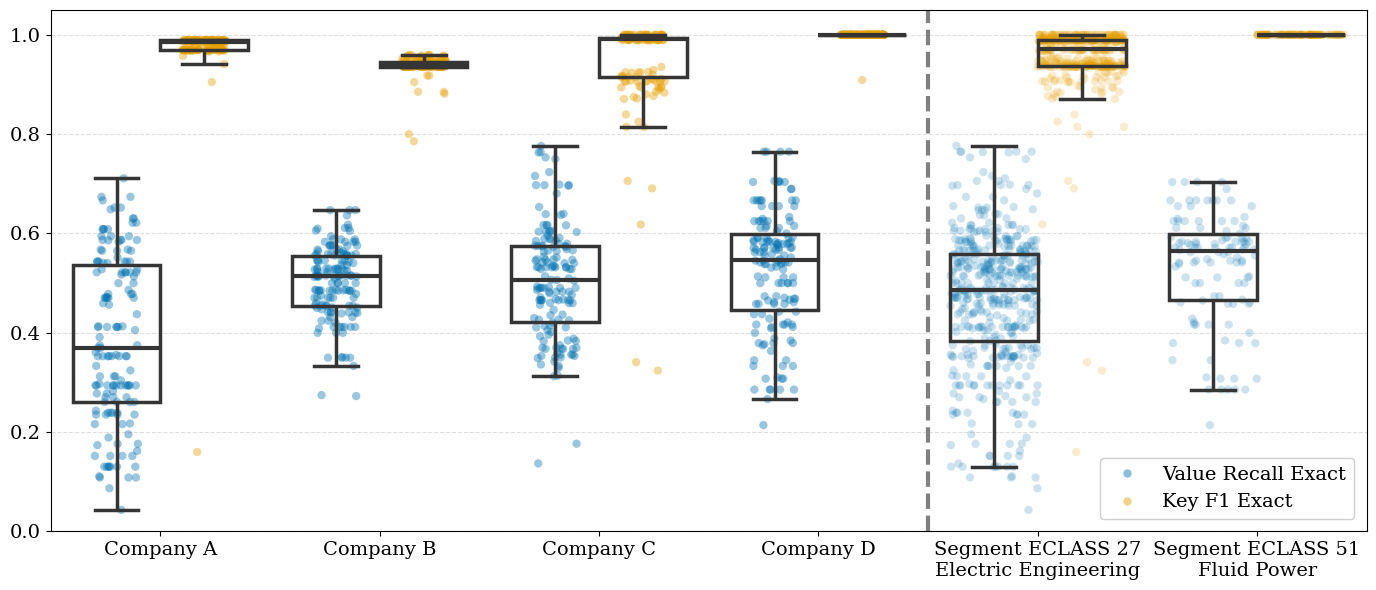

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Your original colors
color1 = '#0072B2'  # blue
color2 = '#E69F00'  # orange
palette = {metric_full_reference: color1, metric_no_reference: color2}
plt.figure(figsize=(14, 6))


df_both_metrics = pd.concat([df_full_reference, df_no_reference])
df_companies = df_both_metrics[df_both_metrics['Company'].isin(['Company A','Company B','Company C','Company D'])]
df_product_segments = df_both_metrics[~df_both_metrics['Company'].isin(['Company A','Company B','Company C','Company D'])]



dodge = 300
np.random.seed(42)
# Add colored strip plots to show individual data points
strip1 = sns.stripplot(
    data=df_companies,
    x='Company',
    y='Score',
    hue='Metric',
    palette=palette,
    size=6,
    alpha=0.4,
    dodge=dodge,
    jitter=0.2,
    zorder=5
)

strip2 = sns.stripplot(
    data=df_product_segments,
    x='Company',
    y='Score',
    hue='Metric',
    palette=palette,
    size=6,
    alpha=0.2,
    dodge=dodge,
    jitter=0.4,
    zorder=5
)

# Create unfilled boxplots (outline only) to show quartiles and median
box1 = sns.boxplot(
    data=df_companies,
    x='Company',
    y='Score',
    hue='Metric',
    palette=palette,
    width=0.8,
    fliersize=0,
    linewidth=2.5,
    dodge=dodge,
    boxprops=dict(facecolor='none', alpha=1),  # No fill, just outline
    medianprops=dict(linewidth=3),  # Emphasize median line#
    zorder=10
)

box2 = sns.boxplot(
    data=df_product_segments,
    x='Company',
    y='Score',
    hue='Metric',
    palette=palette,
    width=0.8,
    fliersize=0,
    linewidth=2.5,
    dodge=dodge,
    boxprops=dict(facecolor='none', alpha=1),  # No fill, just outline
    medianprops=dict(linewidth=3),  # Emphasize median line
    zorder=10
)


# Add vertical separators between companies
num_companies = df_both_metrics['Company'].nunique()
plt.axvline(4 - 0.5, color='gray', linestyle='--', alpha=1.0, linewidth=3)

# Styling
plt.ylim(0, 1.05)

plt.ylabel("", fontsize=14)
plt.xlabel("", fontsize=14)

# Enhanced legend - clean up duplicate entries from multiple plot layers
handles, labels = plt.gca().get_legend_handles_labels()

# Get unique metric handles (first occurrence of each metric)
unique_handles = []
unique_labels = []
seen_labels = set()

for handle, label in zip(handles, labels):
    if label not in seen_labels:
        unique_handles.append(handle)
        unique_labels.append(label)
        seen_labels.add(label)

# Add explanation patches
import matplotlib.patches as mpatches
box_patch = mpatches.Patch(facecolor='none', edgecolor='gray', linewidth=2, 
                          label='Box: Quartiles & Median')
hatched_patch = mpatches.Patch(facecolor='lightgray', alpha=0.3, hatch='///', 
                              edgecolor='none', label='Product Segments')

# Combine all legend elements
all_handles = unique_handles[:2]
all_labels = unique_labels[:2]

legend1 = plt.legend(all_handles, ['Value Recall Exact', 'Key F1 Exact'], 
                    #title="Legend",
                    loc='lower left', 
                    bbox_to_anchor=(0.79, 0.005),
                    fontsize=14)

plt.gca().add_artist(legend1)

plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(r"figure6.svg", dpi=300, bbox_inches="tight")
plt.show()



### 5.4.2 Statistical Tests

Statistical tests are conducted to validate observed differences:

t-test on product segments

ANOVA across manufacturers, including variance ratio and eta-squared calculations

These tests help quantify the significance and effect size of differences in metric performance.

In [57]:
# t-test on product segments

segment1 = df_full_reference[df_full_reference['Company'] == 'Segment ECLASS 51\nFluid Power']['Score']
segment2 = df_full_reference[df_full_reference['Company'] == 'Segment ECLASS 27\nElectric Engineering']['Score']

# Perform two-sample t-test (assuming unequal variances)
t_stat, p_value = stats.ttest_ind(segment1, segment2, equal_var=False)

print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.3f}")

T-statistic: 5.208
P-value: 0.000


In [52]:
# ANOVA
df = df_companies[df_companies['Metric']=='value_recall_1to1']

# df with 'Company' and 'Score' columns
groups = [group["Score"].values for name, group in df.groupby("Company")]
F, p = stats.f_oneway(*groups)

print(f"F = {F:.3f}, p = {p:.3f}")

F = 39.760, p = 0.000


In [53]:
# variance ratio of manufacturers

# group by company
groups = df.groupby('Company')['Score']

# overall mean
grand_mean = df['Score'].mean()

# compute pooled within variance
ss_within = 0
df_within = 0
for company, values in groups:
    n = len(values)
    ss_within += (n - 1) * values.var(ddof=1)
    df_within += n - 1
var_within = ss_within / df_within

# compute between variance
means = groups.mean()
counts = groups.count()
ss_between = sum([counts[company] * (mean - grand_mean)**2 
                 for company, mean in means.items()])
var_between = ss_between / counts.sum()

# variance ratio (within / between)
vr = var_within / var_between


# Example usage:
# df = pd.DataFrame({"Company": [...], "Score": [...]})
# var_within, var_between, vr = variance_ratio(df)
print(f"Within variance: {var_within:.3f}")
print(f"Between variance: {var_between:.3f}")
print(f"Variance ratio (within/between): {vr:.3f}")

Within variance: 0.015
Between variance: 0.003
Variance ratio (within/between): 5.030


In [54]:
# Variance explained by company
def eta_squared(df, company_col="Company", score_col="Score"):
    grand_mean = df[score_col].mean()
    groups = df.groupby(company_col)[score_col]
    
    # Between-group sum of squares
    ss_between = sum(len(values)*(values.mean() - grand_mean)**2 
                     for _, values in groups)
    
    # Total sum of squares
    ss_total = sum((x - grand_mean)**2 for x in df[score_col])
    
    eta2 = ss_between / ss_total
    return eta2

eta2 = eta_squared(df)
print(f"Eta-squared (variance explained differences between companies): {eta2:.3f}")

Eta-squared (variance explained differences between companies): 0.167
